In [24]:
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from numpy import sin, cos, arccos, pi, round

Lendo a CSV e removendo todos os dados com valores de Tp_est iguais a zero

In [2]:
df_raw_data = pd.read_csv('data.csv')
df_raw_data.drop(df_raw_data[df_raw_data['Tp_est'] == 0.0].index, inplace=True);

Remoção inicial de colunas da base geral (2018 a 2022). A colunas removidas foram:
- Unnamed: 0 pois é a coluna de ids
- latitude e longitude pois possuem a mesma informação que as colunas lat e lon;
- distancia: Não agrega valor ao modelo.

In [3]:
df_raw_data.drop(['Unnamed: 0', 'latitude', 'longitude', 'distancia'], axis=1, inplace=True)

Separando o raw data entre treinamento e teste. Anos de 2018 a 2021 para treinamento e 2022 para teste.

In [4]:
raw_train_test_group = df_raw_data.groupby(df_raw_data['time'].str.contains('2022'))

df_raw_train = raw_train_test_group.get_group(False).copy()
df_raw_test = raw_train_test_group.get_group(True).copy()

In [5]:
# dates = ['2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12']
dates = ['2018-01', '2018-02']

raw_train_validation_group = df_raw_train.groupby(df_raw_train['time'].str.contains('|'.join(dates)))
df_raw_train = raw_train_validation_group.get_group(False).copy()
df_raw_validation = raw_train_validation_group.get_group(True).copy()


Remoção das colunas elevation e sweep pois não possuiam valor agregado na base

Para verificar que as colunas elevation e sweep não possuiam valor agregado, foi utilizado a função describe do pandas. Com esta função, foi possível verificar que ambas possuiam média, minimo e maximo identicos, além de um desvio padrão igual a 0, ou seja, todas as linhas possuiam o mesmo valor.

In [6]:
print(df_raw_train.describe()['elevation'], end="\n\n")
print(df_raw_train.describe()['sweep'])

df_raw_train.drop(['elevation', 'sweep'], axis=1, inplace=True)

count    83083.0
mean         0.5
std          0.0
min          0.5
25%          0.5
50%          0.5
75%          0.5
max          0.5
Name: elevation, dtype: float64

count    83083.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: sweep, dtype: float64


Criando 2 DataFrames onde um deles armazena as informações das colunas X e Y da base e o outro armazena as colunas LAT e LON

In [7]:
grouped_by_est = df_raw_train.groupby(['Est'])

df_xy = pd.DataFrame(columns=['est','x', 'y'])
df_lat_lon = pd.DataFrame(columns=['est', 'lat', 'lon'])
for est in grouped_by_est.groups.keys():
    group = grouped_by_est.get_group(est)

    list_xy = [est, group['x'].mean(), group['y'].mean()]
    df_xy = pd.concat([pd.DataFrame([list_xy], columns=df_xy.columns), df_xy], ignore_index=True)

    list_lat_lon = [est, group['lat'].mean(), group['lon'].mean()]
    df_lat_lon = pd.concat([pd.DataFrame([list_lat_lon], columns=df_lat_lon.columns), df_lat_lon], ignore_index=True)

Verificando que os valores X e Y fazer o mesmo papel que os valores de LAT e LON para o calcula da distância entre as estações

In [8]:
def rad2deg(radians):
    degrees = radians * 180 / pi
    return degrees

def deg2rad(degrees):
    radians = degrees * pi / 180
    return radians

theta = df_lat_lon['lon'][0] - df_lat_lon['lon'][1]
distance = 60 * 1.1515 * rad2deg(
    arccos(
        (sin(deg2rad(df_lat_lon['lat'][0])) * sin(deg2rad(df_lat_lon['lat'][1]))) + 
        (cos(deg2rad(df_lat_lon['lat'][0])) * cos(deg2rad(df_lat_lon['lat'][1])) * cos(deg2rad(theta)))
    )
)
distance = round(distance * 1.609344, 5)
print(distance)

# Distância euclidina por meio do numpyu
point1 = np.array((df_xy['x'][0], df_xy['y'][0]))
point2 = np.array((df_xy['x'][1], df_xy['y'][1]))
distance = np.linalg.norm(point1 - point2)
print(round(distance / 1000, 5))


94.62581
94.63207


Plotando um gráfico das posições das estações para ter um auxilio visual na clusterização

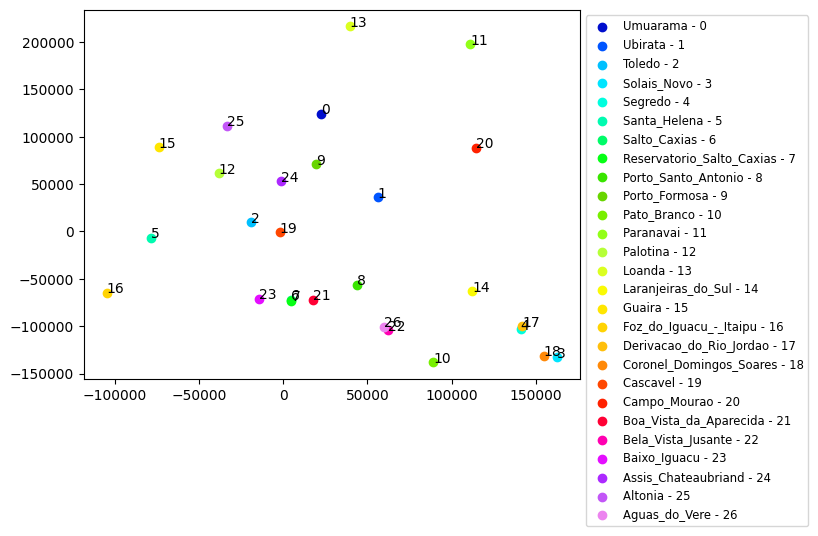

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
for data in df_xy.iterrows():
    ax.scatter(data[1][1], data[1][2], label=f'{data[1][0]} - {data[0]}')

colormap = plt.cm.gist_ncar
colorst = [colormap(i) for i in np.linspace(0.1, 0.9,len(ax.collections))]
for t, j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

for data in df_xy.iterrows():
    ax.annotate(data[0], (data[1][1], data[1][2]))

ax.legend(bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes, fontsize='small')
plt.show()

Calculando a distancia de cada estação entre si para ter um embasamento numérico na decisão da clusterização

In [10]:
def euclidian_distance(x1, y1, x2, y2):
    p1 = np.array((x1, y1))
    p2 = np.array((x2, y2))
    return np.linalg.norm(p1 - p2)

est_distances = []
for est in df_xy.iterrows():
    distances = []
    for row in df_xy.iterrows():
        if est[1][0] != row[1][0]:
            distance = round((euclidian_distance(est[1][1], est[1][2], row[1][1], row[1][2]) / 1000), 3)
            distances.append((distance, row[1][0]))
    distances = sorted(distances)
    distances_sum = sum(i[0] for i in distances[:6])
    est_distances.append((distances_sum, est[1][0], distances))

est_distances = sorted(est_distances)

for est in est_distances:
    print(f'Estação: {est[1]} - Soma: {est[0]} - Estações: {est[2][:6]}')

Estação: Boa_Vista_da_Aparecida - Soma: 193.56199999999998 - Estações: [(12.774, 'Reservatorio_Salto_Caxias'), (12.912, 'Salto_Caxias'), (30.39, 'Porto_Santo_Antonio'), (31.846, 'Baixo_Iguacu'), (50.618, 'Aguas_do_Vere'), (55.022, 'Bela_Vista_Jusante')]
Estação: Reservatorio_Salto_Caxias - Soma: 201.722 - Estações: [(1.255, 'Salto_Caxias'), (12.774, 'Boa_Vista_da_Aparecida'), (19.222, 'Baixo_Iguacu'), (42.255, 'Porto_Santo_Antonio'), (61.042, 'Aguas_do_Vere'), (65.174, 'Bela_Vista_Jusante')]
Estação: Salto_Caxias - Soma: 202.77499999999998 - Estações: [(1.255, 'Reservatorio_Salto_Caxias'), (12.912, 'Boa_Vista_da_Aparecida'), (18.939, 'Baixo_Iguacu'), (41.953, 'Porto_Santo_Antonio'), (61.774, 'Aguas_do_Vere'), (65.942, 'Bela_Vista_Jusante')]
Estação: Segredo - Soma: 261.745 - Estações: [(3.549, 'Derivacao_do_Rio_Jordao'), (30.907, 'Coronel_Domingos_Soares'), (36.857, 'Solais_Novo'), (49.475, 'Laranjeiras_do_Sul'), (62.347, 'Pato_Branco'), (78.61, 'Bela_Vista_Jusante')]
Estação: Derivaca

Remoção das colunas X, Y, Z, LAT, LON, ALT, ja que a partir de agora, a clusterização vai trazer a informação de posicionamento

In [11]:
df_raw_train.drop(['x', 'y', 'z', 'lat', 'lon', 'alt'], axis=1, inplace=True)

Após alguns testes e tentativas de divisão, a clusterização final ficou como:
- Grupo 1: Laranjeiras_do_Sul, Segredo, Derivacao_do_Rio_Jordao, Coronel_Domingos_Soares, Solais_Novo
- Grupo 2: Pato_Branco, Bela_Vista_Jusante, Aguas_do_Vere
- Grupo 3: Baixo_Iguacu, Salto_Caxias, Reservatorio_Salto_Caxias, Boa_Vista_da_Aparecida, Porto_Santo_Antonio
- Grupo 4: Santa_Helena, Foz_do_Iguacu_-_Itaipu
- Grupo 5: Toledo, Cascavel, Assis_Chateaubriand
- Grupo 6: Guaira, Palotina, Altonia
- Grupo 7: Umuarama, Ubirata, Porto_Formosa
- Grupo 8: Loanda, Paranavai, Campo_Mourao

In [19]:
grouped_by_est = df_raw_train.groupby(['Est'])
dict_df_train = {'df_train' : {}, 'for_input': {}}

df_groupped = grouped_by_est.get_group('Laranjeiras_do_Sul')
df_groupped = pd.concat([grouped_by_est.get_group('Segredo'), df_groupped], ignore_index=True)
df_groupped = pd.concat([grouped_by_est.get_group('Derivacao_do_Rio_Jordao'), df_groupped], ignore_index=True)
df_groupped = pd.concat([grouped_by_est.get_group('Coronel_Domingos_Soares'), df_groupped], ignore_index=True)
df_groupped = pd.concat([grouped_by_est.get_group('Solais_Novo'), df_groupped], ignore_index=True)
df_groupped.drop(['Est'], axis=1, inplace=True)
dict_df_train['df_train']['Laranjeiras_do_Sul - Segredo - Derivacao_do_Rio_Jordao - Coronel_Domingos_Soares - Solais_Novo'] = df_groupped

df_groupped = grouped_by_est.get_group('Pato_Branco')
df_groupped = pd.concat([grouped_by_est.get_group('Bela_Vista_Jusante'), df_groupped], ignore_index=True)
df_groupped = pd.concat([grouped_by_est.get_group('Aguas_do_Vere'), df_groupped], ignore_index=True)
df_groupped.drop(['Est'], axis=1, inplace=True)
dict_df_train['df_train']['Pato_Branco - Bela_Vista_Jusante - Aguas_do_Vere'] = df_groupped

df_groupped = grouped_by_est.get_group('Baixo_Iguacu')
df_groupped = pd.concat([grouped_by_est.get_group('Salto_Caxias'), df_groupped], ignore_index=True)
df_groupped = pd.concat([grouped_by_est.get_group('Reservatorio_Salto_Caxias'), df_groupped], ignore_index=True)
df_groupped = pd.concat([grouped_by_est.get_group('Boa_Vista_da_Aparecida'), df_groupped], ignore_index=True)
df_groupped = pd.concat([grouped_by_est.get_group('Porto_Santo_Antonio'), df_groupped], ignore_index=True)
df_groupped.drop(['Est'], axis=1, inplace=True)
dict_df_train['df_train']['Baixo_Iguacu - Salto_Caxias - Reservatorio_Salto_Caxias - Boa_Vista_da_Aparecida - Porto_Santo_Antonio'] = df_groupped

df_groupped = grouped_by_est.get_group('Santa_Helena')
df_groupped = pd.concat([grouped_by_est.get_group('Foz_do_Iguacu_-_Itaipu'), df_groupped], ignore_index=True)
df_groupped.drop(['Est'], axis=1, inplace=True)
dict_df_train['df_train']['Santa_Helena - Foz_do_Iguacu_-_Itaipu'] = df_groupped

df_groupped = grouped_by_est.get_group('Toledo')
df_groupped = pd.concat([grouped_by_est.get_group('Cascavel'), df_groupped], ignore_index=True)
df_groupped = pd.concat([grouped_by_est.get_group('Assis_Chateaubriand'), df_groupped], ignore_index=True)
df_groupped.drop(['Est'], axis=1, inplace=True)
dict_df_train['df_train']['Toledo - Cascavel - Assis_Chateaubriand'] = df_groupped

df_groupped = grouped_by_est.get_group('Guaira')
df_groupped = pd.concat([grouped_by_est.get_group('Palotina'), df_groupped], ignore_index=True)
df_groupped = pd.concat([grouped_by_est.get_group('Altonia'), df_groupped], ignore_index=True)
df_groupped.drop(['Est'], axis=1, inplace=True)
dict_df_train['df_train']['Guaira - Palotina - Altonia'] = df_groupped

df_groupped = grouped_by_est.get_group('Umuarama')
df_groupped = pd.concat([grouped_by_est.get_group('Ubirata'), df_groupped], ignore_index=True)
df_groupped = pd.concat([grouped_by_est.get_group('Porto_Formosa'), df_groupped], ignore_index=True)
df_groupped.drop(['Est'], axis=1, inplace=True)
dict_df_train['df_train']['Umuarama - Ubirata - Porto_Formosa'] = df_groupped

df_groupped = grouped_by_est.get_group('Loanda')
df_groupped = pd.concat([grouped_by_est.get_group('Paranavai'), df_groupped], ignore_index=True)
df_groupped = pd.concat([grouped_by_est.get_group('Campo_Mourao'), df_groupped], ignore_index=True)
df_groupped.drop(['Est'], axis=1, inplace=True)
dict_df_train['df_train']['Loanda - Paranavai - Campo_Mourao'] = df_groupped

for group in dict_df_train['df_train']:
    df_groupped = dict_df_train["df_train"][group].dropna()
    columns = list(df_groupped.head())

    dict_df_train['for_input'][group] = {}
    for row in df_groupped.iterrows():
        timestamp = datetime.strptime(row[1]["time"], '%Y-%m-%d %H:%M:%S').timestamp()

        row_info = {}
        for col in columns:
            row_info[col] = row[1][col]

        dict_df_train['for_input'][group][timestamp] = row_info


O dicionário 'for_input' produzido acima possui as seguintes características:
- Dividido em grupos da mesma forma que os datasets de treinamento;
- Possui apenas as linhas que possuiam todos os dados dos sensores dos datasets de treinamento;
- Foi organizado por meio de dicionários internos com a chave sendo o timestamp do dado para facilitar a busca.

Com este dicionário, o data input foi realizado de forma clusterizada, ou seja, on inputs foram realizados apenas com dados do própio grupo

In [26]:
def get_data(row, input_values):
    timestamp = datetime.strptime(row["time"], '%Y-%m-%d %H:%M:%S').timestamp()

    data = None
    min_distance = math.inf
    for i in input_values:
        distance = abs(timestamp - i)
        if (distance < min_distance):
            min_distance = distance
            data = input_values[i]
            
    return data

def df_input_data(df_group, input_values):
    columns = list(df_group.head())
    for row in df_group.iterrows():
        replace_data = get_data(row[1], input_values)
        for col in columns:
            if str(row[1][col]) == 'nan':
                df_group.loc[row[0], col] = replace_data[col]

for group in dict_df_train['df_train']:
    df_group = dict_df_train['df_train'][group]
    input_values = dict_df_train['for_input'][group]
    df_input_data(df_group, input_values)
    dict_df_train['df_train'][group].drop(['time'], axis=1, inplace=True)

Removendo as colunas da base de validação que foram removidas da base de treinamento

In [27]:
df_validation = df_raw_validation.drop(['elevation', 'sweep', 'x', 'y', 'z', 'lat', 'lon', 'alt'], axis=1,)

Realizando o data imputation na base de validação. O input foi feito da seguinte maneira:

Para realizar o input, primeiro, para cada linha, é buscado o grupo a qual ela pertence, ou seja, de qual grupo de estações o dado veio. Após isso, apenas a base de treinamento é utilizada para o input, sem a influência dos dados da base de validação.

In [28]:
def get_group(est, input_groups):
    for group in input_groups:
        if est in group: return input_groups[group]

columns = list(df_validation.head())
for row in df_validation.iterrows():
    input_values = get_group(row[1]['Est'], dict_df_train['for_input'])
    replace_data = get_data(row[1], input_values)
    for col in columns:
        if str(row[1][col]) == 'nan':
            df_validation.loc[row[0], col] = replace_data[col]

df_validation.drop(['Est', 'time'], axis=1, inplace=True)

To-do: Utilizar a base de validação para definir o modelo que vou usar

In [35]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tem que transformar para string

train_list = dict_df_train['df_train']['Laranjeiras_do_Sul - Segredo - Derivacao_do_Rio_Jordao - Coronel_Domingos_Soares - Solais_Novo'].values.tolist()
validate_list = df_validation.values.tolist()

train_list

# x_train = train_list[:, :-1]
# y_train = train_list[:, -1]

# x_validate = validate_list[:, :-1]
# y_validate = validate_list[:, -1]

# knn_regression = KNeighborsRegressor(n_neighbors=5)
# knn_regression.fit(x_train, y_train)

# pred = knn_regression.predict(x_validate)
# mse = mean_squared_error(y_validate, pred)

# mse

# df_validation.values.tolist()


[[129.0, 210250.0, 7.68, 7.28, 5.45, 4.32, 0.13, 0.9, 0.77, 2.4],
 [129.0, 210250.0, 3.81, 3.26, 3.43, 0.7, 1.58, 0.62, 0.64, 0.2],
 [129.0, 210250.0, 1.54, 1.6, 0.88, 1.28, -0.5, -0.67, 0.45, 1.6],
 [129.0, 210250.0, 1.54, 1.6, 0.88, 1.28, -0.5, 2.14, 0.44, 1.6],
 [129.0, 210250.0, 1.54, 1.6, 0.88, 1.28, -0.5, -2.67, 0.41, 1.8],
 [129.0, 210250.0, 1.54, 1.6, 0.88, 1.28, -0.5, 0.5, 0.4, 0.6],
 [129.0, 210250.0, 1.54, 1.6, 0.88, 1.28, -0.5, 0.5, 0.3, 0.6],
 [129.0, 210250.0, 1.54, 1.6, 0.88, 1.28, -0.5, -1.79, 0.54, 0.2],
 [129.0, 210250.0, 1.54, 1.6, 0.88, 1.28, -0.5, 0.5, 0.46, 0.2],
 [129.0, 210250.0, 25.67, 26.14, 24.85, 25.38, 0.42, 4.44, 0.44, 0.2],
 [129.0, 210250.0, 6.91, 7.16, 6.07, 6.36, 0.23, 0.25, 0.76, 8.6],
 [129.0, 210250.0, 12.85, 13.48, 12.54, 13.26, -0.38, -0.13, 0.89, 5.2],
 [129.0, 210250.0, 14.68, 14.6, 14.6, 14.52, -0.5, 0.58, 0.94, 2.4],
 [129.0, 210250.0, 9.52, 10.83, 9.24, 10.66, -0.42, -0.8, 0.82, 2.0],
 [129.0, 210250.0, 12.14, 12.0, 11.25, 10.93, 0.17, 0.63, 

Removendo as colunas da base de teste que foram removidas da base de treinamento

In [ ]:
df_test = df_raw_test.drop(['elevation', 'sweep', 'x', 'y', 'z', 'lat', 'lon', 'alt'], axis=1,)

Realizando o data imputation na base de teste. O input foi feito da seguinte maneira:

Para realizar o input, primeiro, para cada linha, é buscado o grupo a qual ela pertence, ou seja, de qual grupo de estações o dado veio. Após isso, apenas a base de treinamento é utilizada para o input, sem a influência dos dados da base de teste.

In [ ]:
def get_group(est, input_groups):
    for group in input_groups:
        if est in group: return input_groups[group]

columns = list(df_test.head())
for row in df_test.iterrows():
    input_values = get_group(row[1]['Est'], dict_df_train['for_input'])
    replace_data = get_data(row[1], input_values)
    for col in columns:
        if str(row[1][col]) == 'nan':
            df_test.loc[row[0], col] = replace_data[col]